<h1 align='center'>VIZUALIZING RIVM DATA ON COVID-19 IN THE NETHERLANDS</h1>
<h2 align='center'>[Crawling data, Sending via Telegram, and Visualizing]</h2>

SOURCES IN DUTCH:
- https://www.rivm.nl/nieuws/actuele-informatie-over-coronavirus
- https://www.rivm.nl/coronavirus-kaart-van-nederland-per-gemeente

SOURCES IN ENGLISH
- https://www.rivm.nl/en/news/current-information-about-novel-coronavirus-covid-19
- https://www.rivm.nl/en/coronavirus-map-netherlands-per-municipality

In [421]:
# path = '/Users/santannajj/Desktop/covid19_in_nl/'
path = '/home/pi/covid19_in_nl/'
# path = '/Users/nw/Desktop/covid19_in_nl/'

Required libraries:

In [422]:
import pandas as pd
import numpy as np
import cfscrape
from lxml import etree
import io
import re
import requests

<h1 align='center'>===============================================================<br>
AUTOMATICALLY RETRIEVING DATA FROM GEMEENTES
</h1>

Source:

In [427]:
url="https://www.rivm.nl/coronavirus-kaart-van-nederland-per-gemeente"

Making the HTTP request:

In [428]:
header = {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9',
          'Accept-Encoding': 'gzip, deflate, sdch',
          'Accept-Language' : 'nl-NL,nl;q=0.8,en-US;q=0.6,en;q=0.4',
          'Cache-Control' : 'max-age=0',
          'Connection': 'keep-alive',
          'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.81 Safari/537.36'}

scraper = cfscrape.create_scraper()
scraped_html=scraper.get(url,headers=header).content
html = etree.HTML(scraped_html)

Scrapping the data:

In [429]:
date = html.xpath("//div[@id='mapTitles']/text()")[0].split('tot en met ')[1].split('"')[0]
date = pd.to_datetime(date, format='%d-%m-%Y').strftime('%d-%m-%Y')
time = html.xpath("//p/text()")[0].split()[5]
data = html.xpath("//div[@id='csvData']/text()")

print("Last update from the RIVM page:",date,time)

Last update from the RIVM page: 29-03-2020 14.00


Loading the data in a dataframe:

In [430]:
df_gemeente_current = pd.read_csv(io.StringIO('\n'.join(str(data[0]).split('\n')[1:])), sep=';')

Workaround to get cases in 'unknown' municipalities:

In [431]:
aantal_unknown_gemeente = int(re.findall(r'\d+',html.xpath("//div[@class='container container-spacer-sm content nobg clearfix']/p/text()")[3])[0])
df_gemeente_current.loc[0,'Gemeente']='Unknown'
df_gemeente_current.loc[0,'Aantal']= aantal_unknown_gemeente

Showing first 5 lines:

In [432]:
df_gemeente_current.head()

Gemnr          Gemeente  Aantal   BevAant  Aantal per 100.000 inwoners
0     -1           Unknown     305       NaN                          NaN
1    796  's-Hertogenbosch     131  155113.0                         84.5
2   1680       Aa en Hunze       4   25453.0                         15.7
3    358          Aalsmeer      17   31857.0                         53.4
4    197            Aalten       5   27117.0                         18.4

Saving if new data:

In [433]:
df_gemeente_history = pd.read_csv(path+'data/history_per_gemeente.csv',sep=',',index_col='Unnamed: 0')

if date.replace('-','/') not in df_gemeente_history.columns:
    #save the statistic of today
    df_gemeente_current.to_csv(path+'data/covid19-nl-'+date+'.csv')
    #Temporarilly Changing the name of the column
    df_gemeente_current_temporary = df_gemeente_current.rename(columns={"Aantal": date.replace('-','/')})
    #add aantal/occurrences column to the history
    df_gemeente_history = pd.merge(df_gemeente_history,df_gemeente_current_temporary[['Gemeente',date.replace('-','/')]],on='Gemeente',how='outer')
    #reordering columns
    df_gemeente_history = df_gemeente_history.reindex(sorted(df_gemeente_history.columns,reverse=True), axis=1)
    #save the new history
    df_gemeente_history.to_csv(path+'data/history_per_gemeente.csv')
    print("UHUHHHH new data, bitch!")
else:
    print("We already have this data!")    

We already have this data!


<h1 align='center'>===============================================================<br>
AUTOMATICALLY RETRIEVING OVERALL STATISTICS
</h1>

Source:

In [423]:
url="https://www.rivm.nl/nieuws/actuele-informatie-over-coronavirus"

Making the HTTP request:

In [424]:
header = {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9',
          'Accept-Encoding': 'gzip, deflate, sdch',
          'Accept-Language' : 'nl-NL,nl;q=0.8,en-US;q=0.6,en;q=0.4',
          'Cache-Control' : 'max-age=0',
          'Connection': 'keep-alive',
          'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.81 Safari/537.36'}

scraper = cfscrape.create_scraper()
scraped_html=scraper.get(url,headers=header).content
html = etree.HTML(scraped_html)

Scrapping the data:

In [425]:
positive_tested = int(html.xpath("//li[contains(.,'Het totaal aantal positief geteste patiënten:')]/text()")[0].split(':')[1].split(' ')[1].replace('.',''))
new_patients = int(html.xpath("//li[contains(.,'Het totaal aantal gemelde patiënten opgenomen (geweest) in het ziekenhuis:')]/text()")[0].split(':')[1].split(' ')[2].replace('(+','').replace(')','').replace('.',''))
admitted_hospital = int(html.xpath("//li[contains(.,'Het totaal aantal gemelde patiënten opgenomen (geweest) in het ziekenhuis:')]/text()")[0].split(':')[1].split(' ')[1].replace('.',''))
total_fatalities = int(html.xpath("//li[contains(.,'Het totaal aantal gemelde overleden patiënten')]/text()")[0].split(':')[1].split(' ')[1].replace('.',''))
deceased = int(html.xpath("//li[contains(.,'Het totaal aantal gemelde overleden patiënten')]/text()")[0].split(':')[1].split(' ')[2].replace('(+','').replace(')','').replace('.',''))

Saving if new data:

In [426]:
df_stats=pd.read_csv(path+'data/overall_stats.csv',sep=",")

if date.replace('-','/') not in df_stats['date'].values:
    df_stats = df_stats.append({'date':date.replace('-','/'),
                            'positive_tested': positive_tested,
                           'new_patients':new_patients,
                           'admitted_hospital':admitted_hospital,
                           'total_fatalities':total_fatalities,
                           'deceased':deceased}, ignore_index=True).sort_values(by='date',ascending=False).reset_index(drop=True)
    df_stats.to_csv(path+'data/overall_stats.csv',index=False)
    print("UHUHHHH new data, bitch!")
else:
    print("We already have this data!") 

We already have this data!


<h1 align='center'>===============================================================<br>
TESTING A GEMEENTE NAME
</h1>

In [434]:
df_gemeente_current[df_gemeente_current['Gemeente'].str.contains('Gooise Meren')]

Gemnr      Gemeente  Aantal  BevAant  Aantal per 100.000 inwoners
109   1942  Gooise Meren      25  58041.0                         43.1

<h1 align='center'>===============================================================<br>
DETERMINING THE PREVIOUS DAY
</h1>

In [435]:
previous_day = (pd.to_datetime(date, format='%d-%m-%Y') - np.timedelta64(1, 'D')).strftime('%d-%m-%Y')
print('Previous day:',previous_day)

Previous day: 28-03-2020


<h1 align='center'>===============================================================<br>
PREPARING AND SENDING TELEGRAM MESSAGE
</h1>

### Getting the list of requested Gemeentes:

In [14]:
gemeentes_requested=pd.read_csv(path+'data/requested_municipalities.csv',header=None)[0].values.tolist()
gemeentes_requested.sort()

### Composing the message per Gemeente in the requested list:

In [466]:
message="COVID19 IN THE NETHERLANDS\n"
message+="3 MESSAGES/DAY (9h, 15h and 19h)!\n"
message+="RIVM last update: "+str(date)+" "+ str(time)+"\n"
message+="More info at https://bit.ly/covid19nl"

message+="\n\nCASES [PREVIOUS>>CURRENT NUMBERS]\n"

aantal_total = df_gemeente_current['Aantal'].sum()
message+="- TOTAL IN NL: " + str(int(df_gemeente_history[previous_day.replace('-','/')].sum())) + " >> "+str(aantal_total) +"\n"

for gemeente in gemeentes_requested:
    message += "- in "+gemeente+": "+str(int(df_gemeente_history[df_gemeente_history['Gemeente']==gemeente][previous_day.replace('-','/')].values[0]))+" >> "+str(df_gemeente_current[df_gemeente_current['Gemeente']==gemeente]['Aantal'].values[0])+"\n"
message+="\nTELEGRAM FAILS TO SHOW ALL 355 GEMEENTES!\nWhich municipality should I add here?"
print(message)          


COVID19 IN THE NETHERLANDS
3 MESSAGES/DAY (10h, 15h & 20h)!
RIVM last update: 29-03-2020 14.00
More info at https://bit.ly/covid19nl

#CASES [PREVIOUS>>CURRENT NUMBERS]
- TOTAL IN NL: 9762 >> 10866
- in 's-Hertogenbosch: 117 >> 131
- in Almere: 48 >> 57
- in Altena: 41 >> 41
- in Amersfoort: 63 >> 68
- in Amstelveen: 63 >> 75
- in Amsterdam: 477 >> 530
- in Apeldoorn: 52 >> 53
- in Arnhem: 52 >> 59
- in Bergen op Zoom: 17 >> 17
- in Breda: 227 >> 237
- in Doetinchem: 18 >> 23
- in Eindhoven: 128 >> 139
- in Enschede: 49 >> 55
- in Epe: 20 >> 29
- in Haarlem: 73 >> 81
- in Haarlemmermeer: 45 >> 53
- in Hengelo: 25 >> 32
- in Houten: 52 >> 56
- in Lansingerland: 45 >> 47
- in Leiden: 35 >> 37
- in Leusden: 17 >> 19
- in Meppel: 6 >> 8
- in Montferland: 6 >> 10
- in Nieuwegein: 25 >> 30
- in Nijmegen: 149 >> 178
- in Oost Gelre: 8 >> 11
- in Oude IJsselstreek: 7 >> 10
- in Rheden: 30 >> 34
- in Ridderkerk: 27 >> 33
- in Rotterdam: 308 >> 341
- in Tiel: 27 >> 29
- in Tilburg: 284 >> 306
- 

### Function to send a Telegram message:

In [14]:
def telegram_bot_sendtext(bot_message,token,chatid):
    bot_token = token
    bot_chatID = chatid
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message
    response = requests.get(send_text)
    if response.json()['ok']:
        return "Message Sent!"
    else:
        return "Message failed to be sent!"

### Instantiating the function and sending a Telegram message:

In [15]:
bot_token = pd.read_csv(path+'data/telegram_bot_credentials.csv',header=None)[0].values[0]
bot_chatID = str(pd.read_csv(path+'data/telegram_bot_credentials.csv',header=None)[1].values[0])
# bot_chatID = str(pd.read_csv(path+'data/telegram_bot_credentials.csv',header=None)[2].values[0]) #jair

In [16]:
telegram_bot_sendtext(message,bot_token,bot_chatID)

'Message Sent!'

<h1 align='center'>===================================================<br>
VISUALIZING THE STATISTICS AND DISPLAY AT bit.ly/covid19nl 
</h1>

In [436]:
import pandas as pd
import re

import os

import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('bmh')

from IPython.core.display import display, HTML

import matplotlib.dates as mdates
import plotly
plotly.offline.init_notebook_mode()
import plotly.tools as tls
import plotly.graph_objects as go

from matplotlib.ticker import ScalarFormatter

import json
from collections import OrderedDict
from bokeh.io import output_notebook, export_svgs, save, output_file
from bokeh.plotting import figure, show
from bokeh.models import (GeoJSONDataSource,ColumnDataSource,HoverTool,LogColorMapper,ColorBar,LogTicker)
from bokeh.palettes import Oranges7, RdPu7
output_notebook()

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

### Exporting the history of cases per Gemeente to HTML

In [437]:
with open('_includes/tab_history_per_gemeente.html', 'wt', encoding='utf-8') as file:
    file.write('<div class="table-container">\n')
    file.write(df_gemeente_history.to_html())
    file.write('\n</div>')

### Reading the overall statistics

In [438]:
df_stats['date'] = pd.to_datetime(df_stats['date'], format='%d/%m/%Y') 
df_stats = df_stats.set_index('date')
df_stats.head(2)

positive_tested  new_patients  admitted_hospital  \
date                                                           
2020-03-29            10866           529             3483.0   
2020-03-28             9762          1159             2954.0   

            total_fatalities  deceased  healthcare  
date                                                
2020-03-29               771       132         NaN  
2020-03-28               639        93         NaN

### PLOTTING CUMULATIVE NUMBER OF CASES

In [439]:
fig = plt.figure(figsize=(8, 5))
ax = plt.subplot2grid((1,1), (0,0))

df_stats['positive_tested'].plot(ax=ax,color='red',style='-o',label=str(df_stats['positive_tested'].max())+' Positive Tested')
df_stats['admitted_hospital'].plot(ax=ax,color='orange',style='-o',label=str(int(df_stats['admitted_hospital'].max()))+' Admitted in a Hospital')
# df_stats['healthcare'].plot(ax=ax,color='blue',style='-o',label=str(int(df_stats['healthcare'].max()))+' Healthcare Professionals Positive Tested')
df_stats['total_fatalities'].plot(ax=ax,color='black',style='-o',label=str(int(df_stats['total_fatalities'].max()))+' Deaths')

ax.set_xlabel("Date",color='black')
ax.set_ylabel("# Patients",color='black')
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))

# FOR A BETTER STYLING OF THE GRAPH (I.E LEGEND)
plt.legend([])
ax_list = fig.axes
for ax in ax_list:
    ax.get_legend().remove()
plotly_fig = tls.mpl_to_plotly(fig) # convert from Matplotlib to Plotly
legend = go.layout.Legend(x=0.01,y=0.98,font=dict(size=16),bgcolor='rgba(0,0,0,0)')

plotly_fig.update_layout(showlegend=True, legend=legend,paper_bgcolor='rgb(242,242,242)',margin=dict(b=0,l=0,r=0,t=25),hovermode='x')
plotly.offline.plot(plotly_fig, filename=path+"_includes/overall_cummulative_stats.html")


'/Users/nw/Desktop/covid19_in_nl/_includes/overall_cummulative_stats.html'

### PLOTTING CUMMULATIVE NUMBER OF CASES [LOG SCALE]

In [440]:
fig = plt.figure(figsize=(8, 5))
ax = plt.subplot2grid((1,1), (0,0))

df_stats['positive_tested'].plot(ax=ax,color='red',style='-o',label=str(df_stats['positive_tested'].max())+' Positive Tested')
df_stats['admitted_hospital'].plot(ax=ax,color='orange',style='-o',label=str(int(df_stats['admitted_hospital'].max()))+' Admitted in a Hospital')
# df_stats['healthcare'].plot(ax=ax,color='blue',style='-o',label=str(int(df_stats['healthcare'].max()))+' Healthcare Professionals Positive Tested')
df_stats['total_fatalities'].plot(ax=ax,color='black',style='-o',label=str(int(df_stats['total_fatalities'].max()))+' Deaths')

ax.set_xlabel("Date",color='black')
ax.set_ylabel("# Patients [log scale]",color='black')
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))

ax.set_yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter()) #Showing the y-ticks in 'normal' numbers instead of the scientific notation

# FOR A BETTER STYLING OF THE GRAPH (I.E LEGEND)
plt.legend([])
ax_list = fig.axes
for ax in ax_list:
    ax.get_legend().remove()
plotly_fig = tls.mpl_to_plotly(fig)
legend = go.layout.Legend(x=0.01,y=0.98,font=dict(size=12),bgcolor='rgba(0,0,0,0)')  
plotly_fig.update_layout(showlegend=True, legend=legend,paper_bgcolor='rgb(242,242,242)',margin=dict(b=0,l=0,r=0,t=25),hovermode='x')
plotly.offline.plot(plotly_fig, filename=path+"_includes/overall_cummulative_stats_logarithm.html")

'/Users/nw/Desktop/covid19_in_nl/_includes/overall_cummulative_stats_logarithm.html'

### PREPARING DATA TO PLOT HEATMAP MUNICIPALITIES

Reading the Netherlands map model:

In [441]:
with open(path+'data/municipalities2020.json', 'r') as f: # Retrieved from https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2020_gegeneraliseerd&outputFormat=json
    nl_gemeentes = json.loads(f.read(), object_hook=OrderedDict)

Merging values to the map:

In [442]:
missing=[]
name_dict = {'SÃºdwest-FryslÃ¢n':'Súdwest-Fryslân',
             'Noardeast-FryslÃ¢n':'Noardeast-Fryslân'}

for gemeente in nl_gemeentes['features']: 
    gemeente_name = re.sub(r"[\(\[].*?[\)\]]", "",gemeente['properties']['statnaam']).strip()
    # Replace incorrect municipality names
    if gemeente_name in name_dict.keys():
        gemeente['properties']['statnaam'] = name_dict[gemeente_name]
        gemeente_name = gemeente['properties']['statnaam']    
        
    try:
        value_abs = df_gemeente_current[df_gemeente_current['Gemeente'].str.contains(gemeente_name,case=False)]['Aantal'].values[0]
        value_rel = df_gemeente_current[df_gemeente_current['Gemeente'].str.contains(gemeente_name,case=False)]['Aantal per 100.000 inwoners'].values[0]
    except:
        value_abs = -1
        value_rel = -1
        missing.append(gemeente_name)
        
    gemeente['properties']['created_values_abs'] = int(value_abs)
    gemeente['properties']['created_values_rel'] = int(value_rel)

Converting the merged data to GeoJSON:

In [443]:
geo_source = GeoJSONDataSource(geojson=json.dumps(nl_gemeentes))

### PLOTTING HEATMAP OF CASES PER GEMEENTE (ABSOLUTE NUMBERS)

In [444]:
RdPu7.reverse() #for heatmap 
color_mapper = LogColorMapper(palette=RdPu7,low=1,high=df_gemeente_current['Aantal'].max())

# TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"
TOOLS = "hover"

p = figure(
#     title="Absolute number of COVID-19 cases in Dutch provinces", 
    tools=TOOLS,
     x_axis_location=None, y_axis_location=None
)

p.patches('xs', 'ys', 
          source=geo_source,
          fill_color={'field': 'created_values_abs', 
                      'transform': color_mapper},
          fill_alpha=1, 
          line_color="black", 
          line_width=0.5)


hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Gemeente", "@statnaam"),
    ("Cases", "@created_values_abs"),
]

color_bar = ColorBar(color_mapper=color_mapper, 
#                      ticker=LogTicker(),
                     label_standoff=5, 
                     border_line_color='#f2f2f2',
                     background_fill_color = '#f2f2f2',
                     location=(0,0))
p.add_layout(color_bar, 'right')


p.grid.grid_line_color = '#f2f2f2'
p.background_fill_color = '#f2f2f2'
p.border_fill_color = '#f2f2f2'
p.output_backend = "svg"

output_file("_includes/geo_heatmap_actual_numbers.html")
save(p)

'/Users/nw/Desktop/covid19_in_nl/_includes/geo_heatmap_actual_numbers.html'

Removing some lines from the HTML file:

In [445]:
nfirstlines = []
with open(path+'_includes/geo_heatmap_actual_numbers.html') as f, open("tmp.txt", "w") as out:
    for x in range(5):
        nfirstlines.append(next(f))
    for line in f:
        out.write(line)

os.remove(path+'_includes/geo_heatmap_actual_numbers.html')
os.rename("tmp.txt", path+'_includes/geo_heatmap_actual_numbers.html')

Displaying the heatmap:

In [446]:
display(HTML(path+'_includes/geo_heatmap_actual_numbers.html'))

### PLOTTING HEATMAP OF CASES PER GEMEENTE (RELATIVE NUMBERS)

In [447]:
geo_source = GeoJSONDataSource(geojson=json.dumps(nl_gemeentes))

In [448]:
# Map with relative numbers, same as RIVM map
Oranges7.reverse()
color_mapper = LogColorMapper(palette=Oranges7,low=1,high=df_gemeente_current['Aantal per 100.000 inwoners'].max())

# TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"
TOOLS = "hover"

p1 = figure(
#     title="Relative number of COVID-19 cases in Dutch provinces", 
    tools=TOOLS,
     x_axis_location=None, y_axis_location=None
)

p1.patches('xs', 'ys', 
          source=geo_source,
          fill_color={'field': 'created_values_rel', 
                      'transform': color_mapper},
          fill_alpha=1, 
          line_color="black", 
          line_width=0.5)


hover = p1.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Gemeente", '@statnaam'),
    ("Cases per 100k inhabitants", "@created_values_rel"),
]

color_bar = ColorBar(color_mapper=color_mapper, 
#                      ticker=LogTicker(),
                     label_standoff=5, 
                     border_line_color='#f2f2f2',
                     background_fill_color = '#f2f2f2',
                     location=(0,0))
p1.add_layout(color_bar, 'right')


p1.grid.grid_line_color = '#f2f2f2'
p1.background_fill_color = '#f2f2f2'
p1.border_fill_color = '#f2f2f2'
p1.output_backend = "svg"


# show(p1)
output_file("_includes/geo_heatmap_relative_numbers.html")
save(p1)

'/Users/nw/Desktop/covid19_in_nl/_includes/geo_heatmap_relative_numbers.html'

Removing some lines from the HTML file:

In [449]:
nfirstlines = []
with open(path+'_includes/geo_heatmap_relative_numbers.html') as f, open("tmp.txt", "w") as out:
    for x in range(5):
        nfirstlines.append(next(f))
    for line in f:
        out.write(line)

os.remove(path+'_includes/geo_heatmap_relative_numbers.html')
os.rename("tmp.txt", path+'_includes/geo_heatmap_relative_numbers.html')

Displaying the heatmap:

In [450]:
display(HTML(path+'_includes/geo_heatmap_relative_numbers.html'))

### PLOTTING PIE CHART OF GEMEENTES WITH MORE CASES

In [451]:
n = 10
top_gemeente = df_gemeente_current[['Aantal','Gemeente']].sort_values(by='Aantal', ascending=False).reset_index(drop=True)[:n]

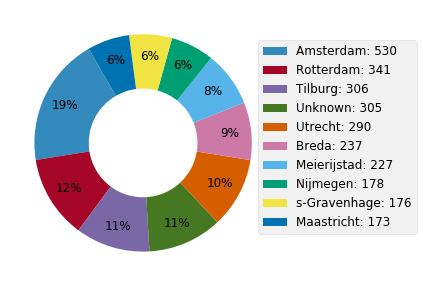

In [452]:
fig = plt.figure(figsize=(5, 5))  
ax1 = plt.subplot2grid((1,1), (0,0))

def my_autopct(pct):
    return ('%.0f' % pct)+"%" if pct > 2 else ''

top_gemeente.plot(ax=ax1,y='Aantal',kind='pie', labels=None, autopct=my_autopct,startangle=120,pctdistance=0.8, labeldistance=1.05,fontsize=12,wedgeprops=dict(width=0.5))
ax1.set_ylabel("")

# For Pie Chart Better Legend boxb
labels = ['{0}: {1}'.format(i,j) for i,j in zip(top_gemeente['Gemeente'], top_gemeente['Aantal'])]
legend_show_top=10
ax1.legend(ax1.patches[0:legend_show_top], 
           labels[0:legend_show_top], 
           bbox_to_anchor=(0.9, 0.9),
           fontsize=12).set_zorder(0)

fig.show()
# fig.savefig(output_figures+'nameservers_pie.eps', bbox_inches='tight',format='eps', dpi=1200)
# fig.savefig(output_figures+'nameservers_pie.png', bbox_inches='tight',format='eps', dpi=1200, transparent=True)

## HISTORY OF ALL GEMEENTES

In [453]:
history = df_gemeente_history.set_index('Gemeente').transpose().sort_index()

In [454]:
history.index = pd.to_datetime(history.index, format='%d/%m/%Y') 

In [455]:
fig = plt.figure(figsize=(8, 10))  
ax = plt.subplot2grid((1,1), (0,0))


history.plot(ax=ax,style='-o')

ax.set_xlabel("Date",color='black')
ax.set_ylabel("# Patients",color='black')
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
# ax.set_yscale('log')

# FOR A BETTER STYLING OF THE GRAPH (I.E LEGEND)
plt.legend([])
ax_list = fig.axes
for ax in ax_list:
    ax.get_legend().remove()
plotly_fig = tls.mpl_to_plotly(fig) # convert from Matplotlib to Plotly
legend = go.layout.Legend(
    x=0.05,y=2.4,
#     font=dict(size=9),
#     bgcolor='rgb(155,155,155)',
    bordercolor='#FFFFFF',
    borderwidth=2,
    orientation="h")


plotly_fig.update_layout(showlegend=True, legend=legend,paper_bgcolor='rgb(242,242,242)',
                         margin=dict(b=0,l=0,r=0,t=110),
                         hovermode='x'
                        )
plotly.offline.plot(plotly_fig, filename=path+"_includes/gemeentes.html")

'/Users/nw/Desktop/covid19_in_nl/_includes/gemeentes.html'